In [1]:
%load_ext autoreload
%autoreload 2

### Triplet Loss

We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.


<img src="./images/triplet.png" height="422" width="722" >

Triplet loss is given by the following :-

$$ \mathcal{L}(I_{1}, I_{2}, I_{3}) = ReLU\{m + (\mathcal{E}_{I_{1}} - \mathcal{E}_{I_{2}})^{2} - (\mathcal{E}_{I_{1}} - \mathcal{E}_{I_{3}})^{2} \}$$

where $\mathcal{E}$ is the final layer embedding of the neural network, $\mathcal{I_{1}}$ is the example from primary domain, $\mathcal{I_{2}}$ is the example from helper domain.  

In [2]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset

# Set up data loaders
from datasets import TripletCD

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet, TripletNet
from losses import ContrastiveLoss, TripletLoss

classes = [i for i in range(10)]
instances = [5000 for i in range(10)]


batch_size=128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [4]:
def showLossHist(lossHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(lossHist['trainLoss']))

    y1 = lossHist['trainLoss']
    y2 = lossHist['valLoss']

    plt.plot(x, y1, label='Training Loss')
    plt.plot(x, y2, label='Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Triplet Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')

    plt.show()

In [5]:
# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('SVHN', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('SVHN', classes, instances, 'test' )


primay_train_loader = torch.utils.data.DataLoader(train_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_train_loader = torch.utils.data.DataLoader(train_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primay_test_loader = torch.utils.data.DataLoader(test_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_test_loader = torch.utils.data.DataLoader(test_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

triplet_train_dataset=TripletCD(train_dataset_primary, train_dataset_helper)
triplet_test_dataset=TripletCD(test_dataset_primary, test_dataset_helper)

triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [6]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(primary_embeddings, primary_targets, helper_embeddings, helper_targets):
    
    plt.figure(figsize=(10,10))
    
    for i in range(10):
        primary_inds = np.where(primary_targets==i)[0]
        plt.scatter(primary_embeddings[primary_inds,0], primary_embeddings[primary_inds,1],  marker=(4,0,0), alpha=0.3, color=colors[i], s=100)
        
        helper_inds = np.where(helper_targets==i)[0]
        plt.scatter(helper_embeddings[helper_inds,0], helper_embeddings[helper_inds,1],  marker='o', alpha=0.3, color=colors[i], s=100)

    #plt.legend(mnist_classes)

def extract_embeddings(dataloader, model, domain='primary'):
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 2))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for images, target in dataloader:
        images = Variable(images, volatile=True)
        if cuda:
            images = images.cuda()
        embeddings[k:k+len(images)] = model.get_embedding(images, domain).data.cpu().numpy()
        labels[k:k+len(images)] = target.numpy()
        k += len(images)
    return embeddings, labels

In [7]:
margin = 1.
embedding_net_primary = EmbeddingNet(1)
embedding_net_helper = EmbeddingNet(3)

model = TripletNet(embedding_net_primary, embedding_net_helper)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

Train: [0/50000 (0%)]	Loss: 0.999862
Train: [12800/50000 (26%)]	Loss: 1.002074
Train: [25600/50000 (51%)]	Loss: 0.862481
Train: [38400/50000 (77%)]	Loss: 0.538482
Epoch: 1/20. Train set: Average loss: 0.7101
Epoch: 1/20. Validation set: Average loss: 0.3853
Train: [0/50000 (0%)]	Loss: 0.371124
Train: [12800/50000 (26%)]	Loss: 0.340912
Train: [25600/50000 (51%)]	Loss: 0.308336
Train: [38400/50000 (77%)]	Loss: 0.281160
Epoch: 2/20. Train set: Average loss: 0.2987
Epoch: 2/20. Validation set: Average loss: 0.2846
Train: [0/50000 (0%)]	Loss: 0.338476
Train: [12800/50000 (26%)]	Loss: 0.230719
Train: [25600/50000 (51%)]	Loss: 0.211942
Train: [38400/50000 (77%)]	Loss: 0.211449
Epoch: 3/20. Train set: Average loss: 0.2138
Epoch: 3/20. Validation set: Average loss: 0.2289
Train: [0/50000 (0%)]	Loss: 0.202894
Train: [12800/50000 (26%)]	Loss: 0.196143
Train: [25600/50000 (51%)]	Loss: 0.168954
Train: [38400/50000 (77%)]	Loss: 0.169984
Epoch: 4/20. Train set: Average loss: 0.1743
Epoch: 4/20. Valid

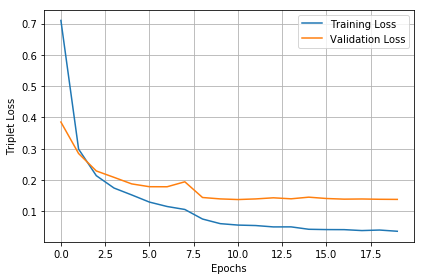

In [8]:
lossDict = fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

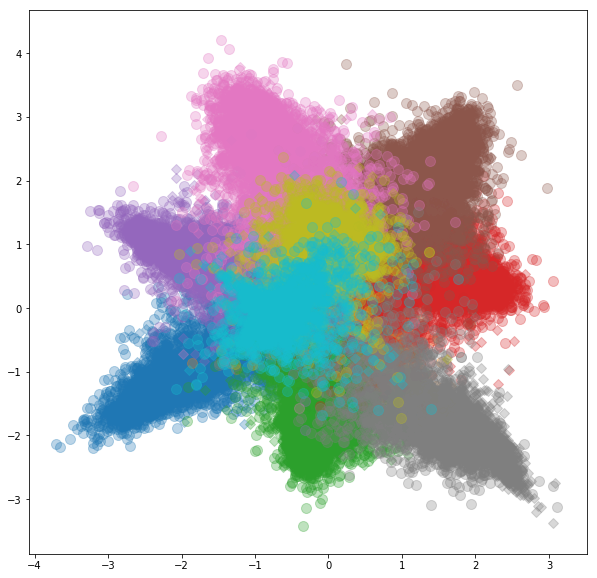

In [9]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

### Conducting the same experiments for 'USPS'

In [10]:
# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('USPS', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('USPS', classes, instances, 'test' )


primay_train_loader = torch.utils.data.DataLoader(train_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_train_loader = torch.utils.data.DataLoader(train_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primay_test_loader = torch.utils.data.DataLoader(test_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_test_loader = torch.utils.data.DataLoader(test_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

triplet_train_dataset=TripletCD(train_dataset_primary, train_dataset_helper)
triplet_test_dataset=TripletCD(test_dataset_primary, test_dataset_helper)


triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [11]:
margin = 1.
embedding_net_primary = EmbeddingNet(1)
embedding_net_helper = EmbeddingNet(1)

model = TripletNet(embedding_net_primary, embedding_net_helper)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

Train: [0/50000 (0%)]	Loss: 1.000000
Train: [12800/50000 (26%)]	Loss: 0.375975
Train: [25600/50000 (51%)]	Loss: 0.178074
Train: [38400/50000 (77%)]	Loss: 0.126522
Epoch: 1/20. Train set: Average loss: 0.2031
Epoch: 1/20. Validation set: Average loss: 0.0891
Train: [0/50000 (0%)]	Loss: 0.051383
Train: [12800/50000 (26%)]	Loss: 0.092768
Train: [25600/50000 (51%)]	Loss: 0.096164
Train: [38400/50000 (77%)]	Loss: 0.066454
Epoch: 2/20. Train set: Average loss: 0.0811
Epoch: 2/20. Validation set: Average loss: 0.0720
Train: [0/50000 (0%)]	Loss: 0.067340
Train: [12800/50000 (26%)]	Loss: 0.056569
Train: [25600/50000 (51%)]	Loss: 0.050394
Train: [38400/50000 (77%)]	Loss: 0.051364
Epoch: 3/20. Train set: Average loss: 0.0512
Epoch: 3/20. Validation set: Average loss: 0.0509
Train: [0/50000 (0%)]	Loss: 0.079103
Train: [12800/50000 (26%)]	Loss: 0.042289
Train: [25600/50000 (51%)]	Loss: 0.043826
Train: [38400/50000 (77%)]	Loss: 0.042263
Epoch: 4/20. Train set: Average loss: 0.0425
Epoch: 4/20. Valid

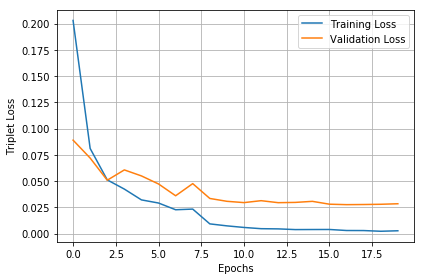

In [12]:
lossDict=fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

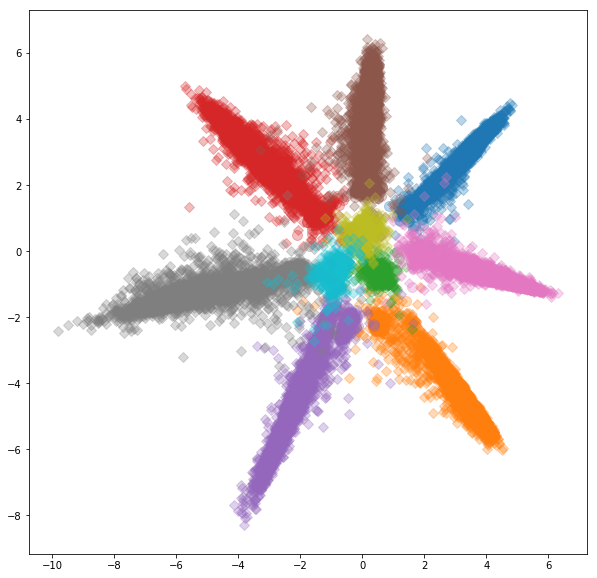

In [14]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

## Hard Negative Mining

### MNIST and SVHN

In [22]:
# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('SVHN', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('SVHN', classes, instances, 'test' )

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler_primary = BalancedBatchSampler(train_dataset_primary, n_classes=10, n_samples=25)
test_batch_sampler_primary = BalancedBatchSampler(test_dataset_primary, n_classes=10, n_samples=25)

train_batch_sampler_helper = BalancedBatchSampler(train_dataset_helper, n_classes=10, n_samples=25)
test_batch_sampler_helper = BalancedBatchSampler(test_dataset_helper, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}


online_train_loader_primary = torch.utils.data.DataLoader(train_dataset_primary, 
                                                          batch_sampler=train_batch_sampler_primary, 
                                                          **kwargs)
online_test_loader_primary = torch.utils.data.DataLoader(test_dataset_primary, 
                                                         batch_sampler=test_batch_sampler_primary, 
                                                         **kwargs)

online_train_loader_helper = torch.utils.data.DataLoader(train_dataset_helper, 
                                                          batch_sampler=train_batch_sampler_helper, 
                                                          **kwargs)
online_test_loader_helper = torch.utils.data.DataLoader(test_dataset_helper, 
                                                         batch_sampler=test_batch_sampler_helper, 
                                                         **kwargs)


# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import OnlineTripletLoss2
from utils import AllTripletSelector2,HardestNegativeTripletSelector2, RandomNegativeTripletSelector2, SemihardNegativeTripletSelector2 # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric
from trainer import fit2

margin = 1.
embedding_net_primary = EmbeddingNet(1)
embedding_net_helper = EmbeddingNet(3)


model = TripletNet(embedding_net_primary, embedding_net_helper)

if cuda:
    model.cuda()
    
loss_fn = OnlineTripletLoss2(margin, RandomNegativeTripletSelector2(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 50
log_interval = 50

In [ ]:
lossDict = fit2(online_train_loader_primary,
     online_test_loader_primary,
     online_train_loader_helper,
     online_test_loader_helper,
     model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, mode='triplet', metrics=[AverageNonzeroTripletsMetric()])
showLossHist(lossDict)

Train: [0/50000 (0%)]	Loss: 1.000003	Average nonzero triplets: 6250.0
Train: [50/50000 (25%)]	Loss: 1.002897	Average nonzero triplets: 6250.0
Train: [100/50000 (50%)]	Loss: 0.894759	Average nonzero triplets: 6240.53465347
Train: [150/50000 (75%)]	Loss: 0.690245	Average nonzero triplets: 6177.43708609
Epoch: 1/50. Train set: Average loss: 0.7866	Average nonzero triplets: 6099.6010101
Epoch: 1/50. Validation set: Average loss: 0.5890	Average nonzero triplets: 5828.38461538
Train: [0/50000 (0%)]	Loss: 0.472157	Average nonzero triplets: 5817.0
Train: [50/50000 (25%)]	Loss: 0.450107	Average nonzero triplets: 5743.62745098
Train: [100/50000 (50%)]	Loss: 0.400185	Average nonzero triplets: 5717.63366337
Train: [150/50000 (75%)]	Loss: 0.346657	Average nonzero triplets: 5669.68211921
Epoch: 2/50. Train set: Average loss: 0.3836	Average nonzero triplets: 5650.25757576
Epoch: 2/50. Validation set: Average loss: 0.3431	Average nonzero triplets: 5636.0
Train: [0/50000 (0%)]	Loss: 0.287209	Average no

Train: [0/50000 (0%)]	Loss: 0.016082	Average nonzero triplets: 4776.0
Train: [50/50000 (25%)]	Loss: 0.026207	Average nonzero triplets: 4721.0
Train: [100/50000 (50%)]	Loss: 0.030259	Average nonzero triplets: 4685.12871287
Train: [150/50000 (75%)]	Loss: 0.033819	Average nonzero triplets: 4661.87417219
Epoch: 18/50. Train set: Average loss: 0.0293	Average nonzero triplets: 4645.26767677
Epoch: 18/50. Validation set: Average loss: 0.3020	Average nonzero triplets: 4968.61538462
Train: [0/50000 (0%)]	Loss: 0.016270	Average nonzero triplets: 4727.0
Train: [50/50000 (25%)]	Loss: 0.025946	Average nonzero triplets: 4629.78431373
Train: [100/50000 (50%)]	Loss: 0.025677	Average nonzero triplets: 4615.85148515
Train: [150/50000 (75%)]	Loss: 0.026309	Average nonzero triplets: 4605.28476821
Epoch: 19/50. Train set: Average loss: 0.0266	Average nonzero triplets: 4601.75757576
Epoch: 19/50. Validation set: Average loss: 0.2965	Average nonzero triplets: 5003.43589744
Train: [0/50000 (0%)]	Loss: 0.01844

In [ ]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

### MNIST and USPS

In [ ]:
# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('USPS', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('USPS', classes, instances, 'test' )

In [18]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler_primary = BalancedBatchSampler(train_dataset_primary, n_classes=10, n_samples=25)
test_batch_sampler_primary = BalancedBatchSampler(test_dataset_primary, n_classes=10, n_samples=25)

train_batch_sampler_helper = BalancedBatchSampler(train_dataset_helper, n_classes=10, n_samples=25)
test_batch_sampler_helper = BalancedBatchSampler(test_dataset_helper, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}


online_train_loader_primary = torch.utils.data.DataLoader(train_dataset_primary, 
                                                          batch_sampler=train_batch_sampler_primary, 
                                                          **kwargs)
online_test_loader_primary = torch.utils.data.DataLoader(test_dataset_primary, 
                                                         batch_sampler=test_batch_sampler_primary, 
                                                         **kwargs)

online_train_loader_helper = torch.utils.data.DataLoader(train_dataset_helper, 
                                                          batch_sampler=train_batch_sampler_helper, 
                                                          **kwargs)
online_test_loader_helper = torch.utils.data.DataLoader(test_dataset_helper, 
                                                         batch_sampler=test_batch_sampler_helper, 
                                                         **kwargs)


# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import OnlineTripletLoss2
from utils import AllTripletSelector2,HardestNegativeTripletSelector2, RandomNegativeTripletSelector2, SemihardNegativeTripletSelector2 # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric
from trainer import fit2

margin = 1.
embedding_net_primary = EmbeddingNet(1)
embedding_net_helper = EmbeddingNet(1)


model = TripletNet(embedding_net_primary, embedding_net_helper)

if cuda:
    model.cuda()
    
loss_fn = OnlineTripletLoss2(margin, RandomNegativeTripletSelector2(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 50
log_interval = 50

In [19]:
lossDict = fit2(online_train_loader_primary,
     online_test_loader_primary,
     online_train_loader_helper,
     online_test_loader_helper,
     model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, mode='triplet', metrics=[AverageNonzeroTripletsMetric()])

Train: [0/50000 (0%)]	Loss: 0.999944	Average nonzero triplets: 6250.0
Epoch: 1/50. Train set: Average loss: 1.0292	Average nonzero triplets: 6240.38888889
Epoch: 1/50. Validation set: Average loss: 0.3200	Average nonzero triplets: 6138.22222222
Train: [0/50000 (0%)]	Loss: 0.722092	Average nonzero triplets: 6242.0
Epoch: 2/50. Train set: Average loss: 0.6936	Average nonzero triplets: 5872.61111111
Epoch: 2/50. Validation set: Average loss: 0.2531	Average nonzero triplets: 5394.33333333
Train: [0/50000 (0%)]	Loss: 0.534213	Average nonzero triplets: 4981.0
Epoch: 3/50. Train set: Average loss: 0.5020	Average nonzero triplets: 5039.83333333
Epoch: 3/50. Validation set: Average loss: 0.1964	Average nonzero triplets: 4979.33333333
Train: [0/50000 (0%)]	Loss: 0.346848	Average nonzero triplets: 4554.0
Epoch: 4/50. Train set: Average loss: 0.4424	Average nonzero triplets: 4872.44444444
Epoch: 4/50. Validation set: Average loss: 0.1848	Average nonzero triplets: 4882.83333333
Train: [0/50000 (0%)

Train: [0/50000 (0%)]	Loss: 0.116493	Average nonzero triplets: 5154.0
Epoch: 35/50. Train set: Average loss: 0.1399	Average nonzero triplets: 4690.11111111
Epoch: 35/50. Validation set: Average loss: 0.0633	Average nonzero triplets: 4744.55555556
Train: [0/50000 (0%)]	Loss: 0.105814	Average nonzero triplets: 4627.0
Epoch: 36/50. Train set: Average loss: 0.1348	Average nonzero triplets: 4781.05555556
Epoch: 36/50. Validation set: Average loss: 0.0668	Average nonzero triplets: 4761.72222222
Train: [0/50000 (0%)]	Loss: 0.105088	Average nonzero triplets: 4490.0
Epoch: 37/50. Train set: Average loss: 0.1308	Average nonzero triplets: 4769.0
Epoch: 37/50. Validation set: Average loss: 0.0696	Average nonzero triplets: 4769.11111111
Train: [0/50000 (0%)]	Loss: 0.126257	Average nonzero triplets: 4691.0
Epoch: 38/50. Train set: Average loss: 0.1296	Average nonzero triplets: 4711.5
Epoch: 38/50. Validation set: Average loss: 0.0665	Average nonzero triplets: 4791.16666667
Train: [0/50000 (0%)]	Loss

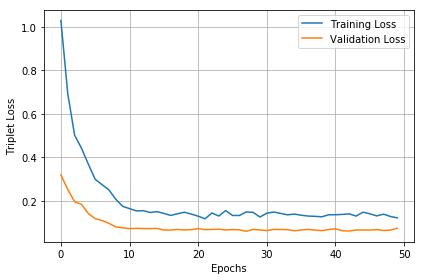

In [20]:
showLossHist(lossDict)

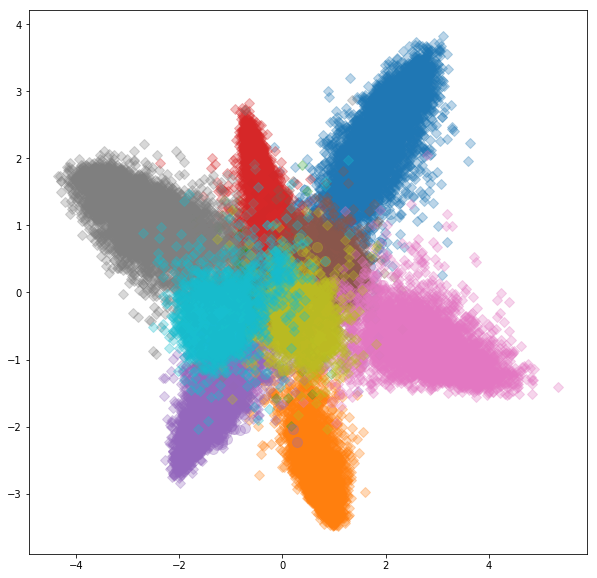

In [21]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)